In [1]:
import numpy as np
import h5py
%matplotlib inline
from IPython.display import Image

%load_ext autoreload
%autoreload 2

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize': 'x-large',
         'xtick.labelsize': 'large',
         'ytick.labelsize': 'large'}
pylab.rcParams.update(params)

from astropy.visualization import make_lupton_rgb

In [2]:
#tag = 'gri_cosmos'
tag = 'gri'
imarr_fn = '../data/images_h5/images_{}.h5'.format(tag)
results_fn = '../results/results_{}.h5'.format(tag)
imdict_fn = '../data/idxdicts_h5/idx2imloc_{}.npy'.format(tag)
resdict_fn = '../data/idxdicts_h5/idx2resloc_{}.npy'.format(tag)

In [3]:
plot_dir = '../papers/images'

In [4]:
imarr = h5py.File(imarr_fn, 'r')
res = h5py.File(results_fn, 'r')
print(imarr.keys())
print(res.keys())
print(len(imarr['idxs']))

<KeysViewHDF5 ['idxs', 'images', 'object_ids']>
<KeysViewHDF5 ['anomaly_scores', 'disc_scores', 'gen_scores', 'idxs', 'object_ids', 'reconstructed']>
942782


In [29]:
idx2imloc = np.load(imdict_fn, allow_pickle=True).item()
idx2resloc = np.load(resdict_fn, allow_pickle=True).item()

In [6]:
# idx2imloc = {}
# for i in range(len(imarr['idxs'])):
#     if i%100000==0: 
#         print(i)
#     idx2imloc[imarr['idxs'][i]] = i

In [7]:
# idx2resloc = {}
# for i in range(len(res['idxs'])):
#     if i%100000==0: 
#         print(i)
#     idx2resloc[res['idxs'][i]] = i

In [8]:
def luptonize(x, rgb_q=15, rgb_stretch=0.5, rgb_min=0):
    if x.ndim==3:
        x = make_lupton_rgb(x[:,:,2], x[:,:,1], x[:,:,0],
                      Q=rgb_q, stretch=rgb_stretch, minimum=rgb_min)
    elif x.ndim==4:
        x = np.array([make_lupton_rgb(xi[:,:,2], xi[:,:,1], xi[:,:,0],
                      Q=rgb_q, stretch=rgb_stretch, minimum=rgb_min)
                      for xi in x])
    else:
        raise ValueError(f"Wrong number of dimensions! Gave {x.ndim}, need 3 or 4")
    return x

In [9]:
def plot_ims(ids, nrows, ncols, saveto=None):
    assert len(ids)<=nrows*ncols, "bad rows/cols for number of ids!"
    
    subsize = 2
    fig, axarr = plt.subplots(nrows,ncols,figsize=(nrows*subsize,ncols*subsize))
    plt.subplots_adjust(hspace=0.2, wspace=0.05)

    count = 0
    for i in range(nrows):
        for j in range(ncols):
            idx = ids[count]
            loc = idx2imloc[idx]
            im = imarr['images'][loc]
            obj_id = int(imarr['object_ids'][loc])
            ax = axarr[i][j]
            title = f"ID: {obj_id}"
            ax.set_title(title, fontsize=8)
            ax.imshow(luptonize(im))
            ax.set_xticks([])
            ax.set_yticks([])
            count += 1
            
            if count>=len(ids):
                break
                
    if saveto:
        plt.savefig(saveto)

In [10]:
bluecore_ids = [935055, 936569, 936288, 782291]
sf_ids = [461525, 702705, 402208, 549909]
tidal_ids = [406992,105162,232476,402855] #936581

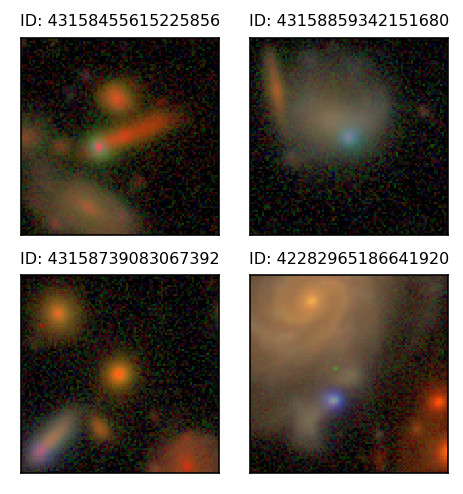

In [11]:
plot_ims(bluecore_ids, 2, 2, saveto=f'{plot_dir}/anomalies_bluecore.png')

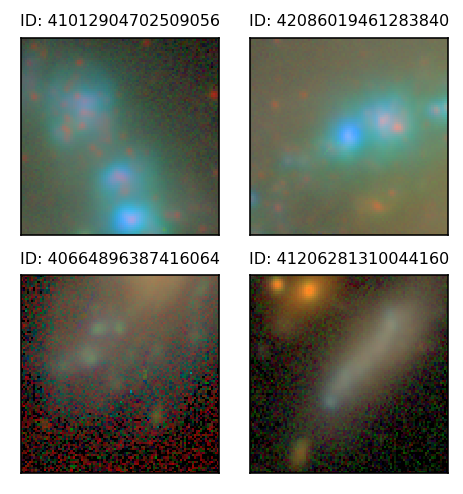

In [12]:
plot_ims(sf_ids, 2, 2, saveto=f'{plot_dir}/anomalies_starforming.png')

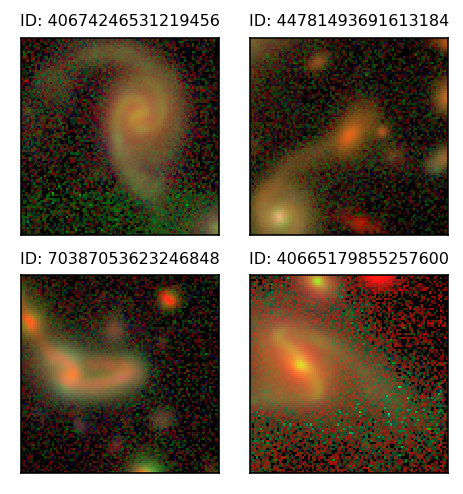

In [13]:
plot_ims(tidal_ids, 2, 2, saveto=f'{plot_dir}/anomalies_tidalfeatures.png')

In [14]:
def get_residual(im, recon):
    im = np.array(im)
    reals = im.reshape((96,96,-1))
    #reals = luptonize(reals).astype('int')
    recon = np.array(recon)
    recon = recon.reshape((96,96,-1)).astype('int')
    resid = abs(im-recon)
    return resid

In [15]:
def plot_recons(ids, saveto=None):
    nims = len(ids)
    subsize = 2
    fig, axarr = plt.subplots(3,nims,figsize=(nims*subsize,3*subsize))
    plt.subplots_adjust(hspace=0.02, wspace=0.1)
    count = 0
    for i in range(nims):
        idx = ids[i]
        
        loc = idx2imloc[idx]
        im = luptonize(imarr['images'][loc])
        obj_id = int(imarr['object_ids'][loc])
        
        rloc = idx2resloc[idx]
        recon = res['reconstructed'][rloc]
        score = float(res['anomaly_scores'][rloc])
        resid = get_residual(im, recon)
        
        ax0 = axarr[0][i]
        ax1 = axarr[1][i]
        ax2 = axarr[2][i]
        title = r'''ID: {}
$s_\mathrm{{anom}}$ = {:.2f}'''.format(obj_id, score)
        ax0.set_title(title, fontsize=8)
        ax0.imshow(im)
        ax1.imshow(recon)
        ax2.imshow(resid)
        
        if i==0:
            fsize=13
            ax0.set_ylabel("real",fontsize=fsize)
            ax1.set_ylabel("reconstructed",fontsize=fsize)
            ax2.set_ylabel("residual",fontsize=fsize)
        
        for ax in [ax0, ax1, ax2]:
            ax.set_xticks([])
            ax.set_yticks([])
          
    if saveto:
        plt.savefig(saveto)

In [35]:
def plot_dist(scores_all, bins=150, save_fn=None, labels=None):
    plt.figure(figsize=(7,5))
    scores_all = np.array(scores_all)
    print(scores_all.shape)
    if not isinstance(scores_all[0], list) or isinstance(scores_all[0], np.ndarray):
        print("Single array, adding outer list")
        scores_all = [scores_all]
        colors = ['blue']
        lcolors = ['black']
    else:
        color_idx = np.linspace(0, 1, len(scores_all))
        colors = [plt.cm.rainbow(color_idx[i]) for i in range(len(scores_all))]
        lcolors = colors
    for i in range(len(scores_all)):
        scores = scores_all[i]
        color = colors[i]
        lcolor = lcolors[i]
        print(len(scores))
        mean = np.mean(scores)
        std = np.std(scores)
        print(len([s for s in scores if s>mean+3*std]))
        #color = plt.cm.rainbow(color_idx[i])
        if labels is not None:
            plt.hist(scores, bins=bins, histtype='step', color=color, lw=2, label=labels[i])
            plt.legend()
        else:
            plt.hist(scores, bins=bins, histtype='step', color=color, lw=2)
        plt.axvline(mean, lw=1, color=lcolor)
        plt.axvline(mean+std, lw=0.8, color=lcolor, ls='--')
        plt.axvline(mean-std, lw=0.8, color=lcolor, ls='--')
        plt.axvline(mean+2*std, lw=0.6, color=lcolor, ls='--')
        plt.axvline(mean-2*std, lw=0.6, color=lcolor, ls='--')
        plt.axvline(mean+3*std, lw=0.4, color=lcolor, ls='--')
        plt.axvline(mean-3*std, lw=0.4, color=lcolor, ls='--')
    plt.xlabel('anomaly score')
    plt.ylabel('#')
    plt.xlim(0,4000)
    if save_fn:
        plt.savefig(save_fn)

In [72]:
scores = res['anomaly_scores']
ridxs = res['idxs']

(942781,)
Single array, adding outer list
942781
9648


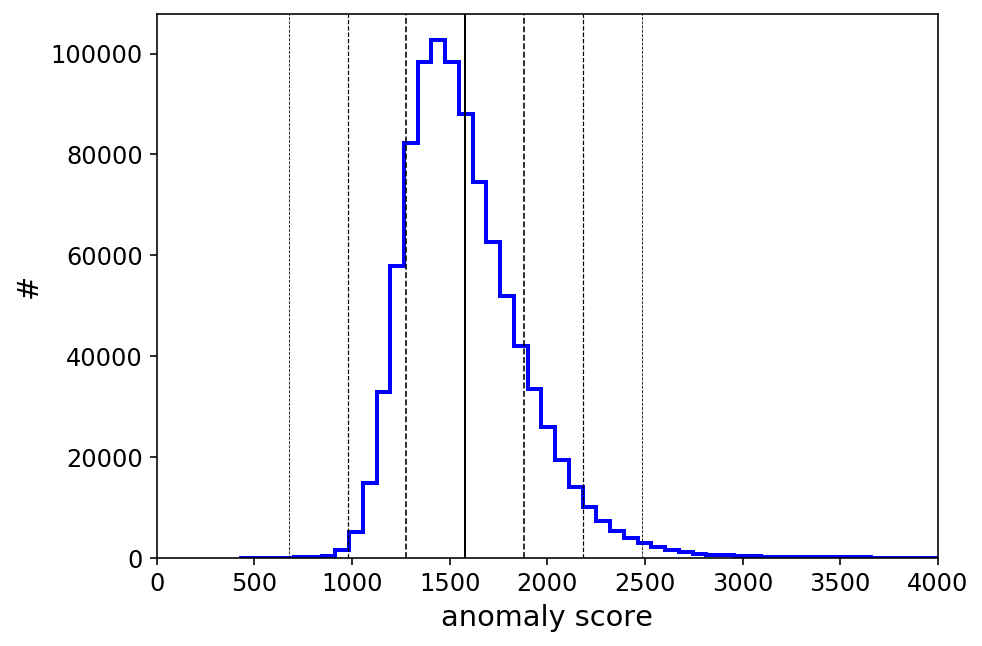

In [37]:
plot_dist(scores)

In [75]:
np.random.seed(17)
def get_anomalies(scores, idxs, sigma_min, sigma_max, n=5):
    scores = np.array(scores)
    mean = np.mean(scores)
    std = np.std(scores)
    amin = mean+sigma_min*std
    amax = mean+sigma_max*std
    aindices = np.where((scores >= amin) & (scores < amax))[0]
    aindices_n = np.random.choice(aindices, n)
    return np.array(idxs)[aindices_n]

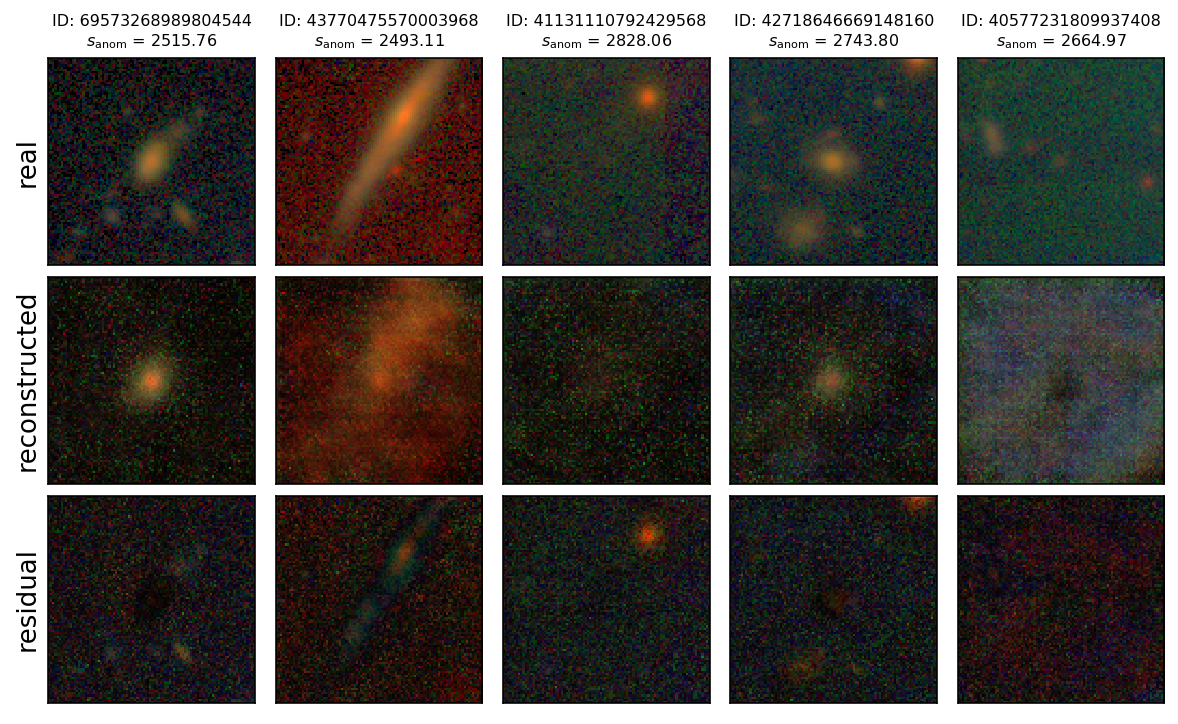

In [76]:
ids_35sig = get_anomalies(scores, ridxs, 3, 5)
plot_recons(ids_35sig)

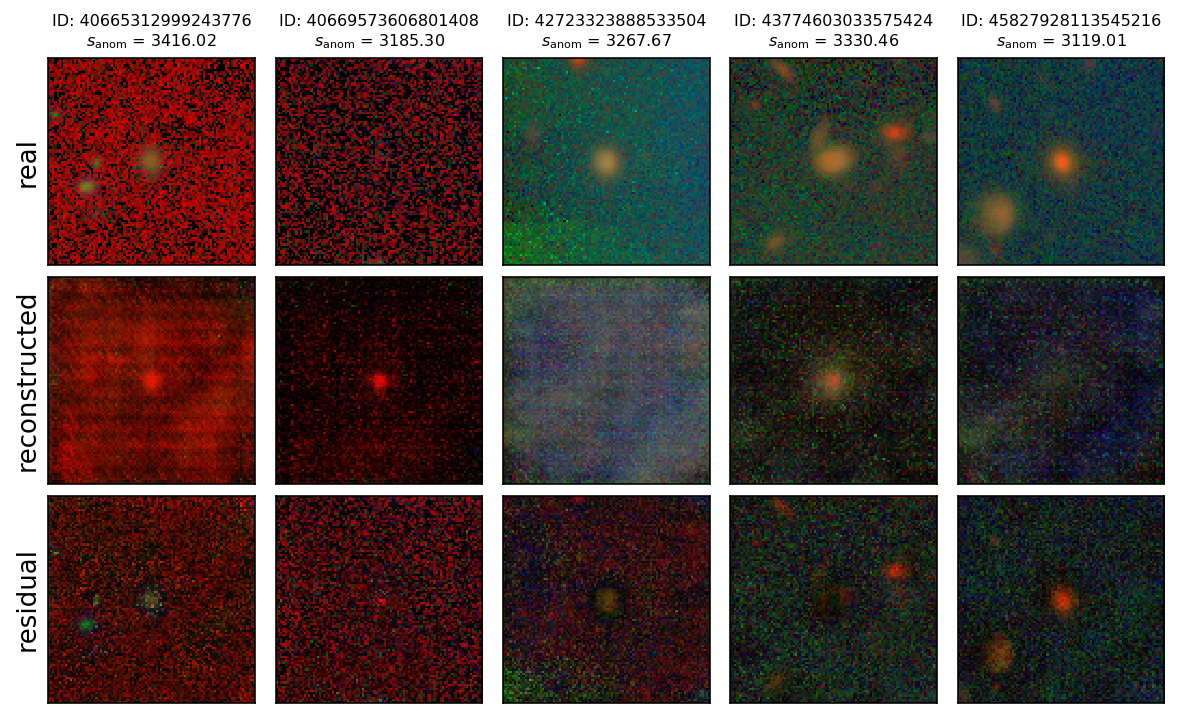

In [77]:
ids_59sig = get_anomalies(scores, ridxs, 5, 9)
plot_recons(ids_59sig)

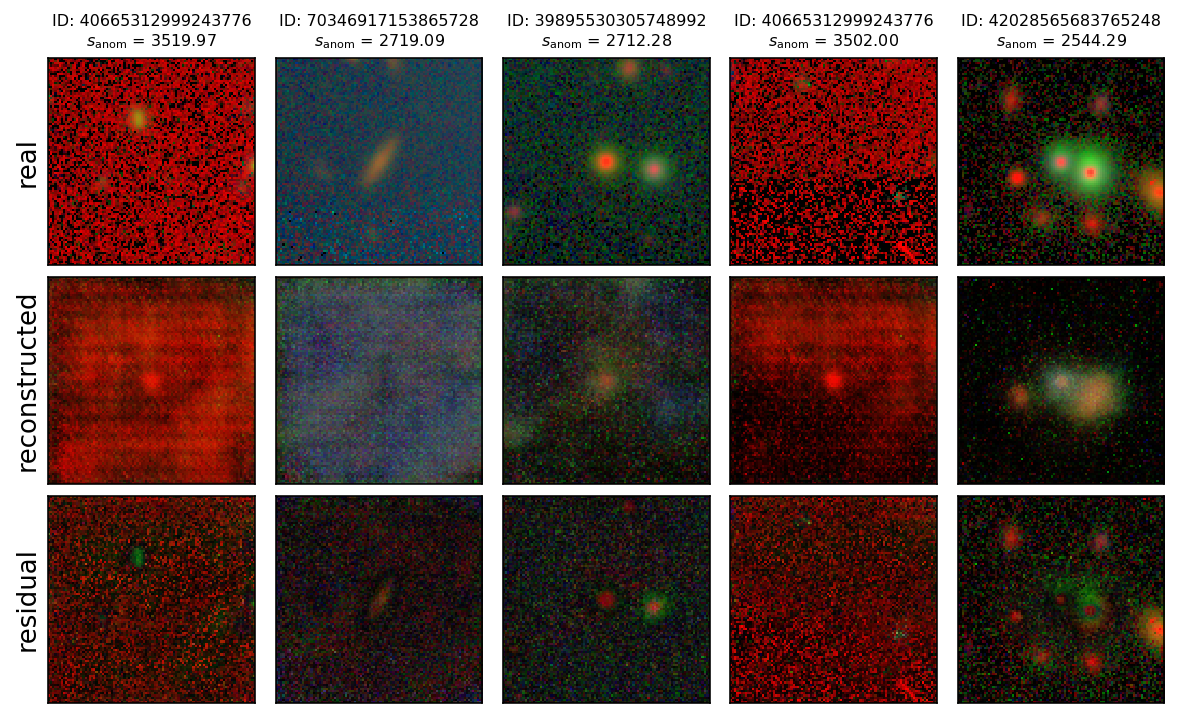

In [78]:
ids_3sig = get_anomalies(scores, ridxs, 3, 10)
plot_recons(ids_3sig)

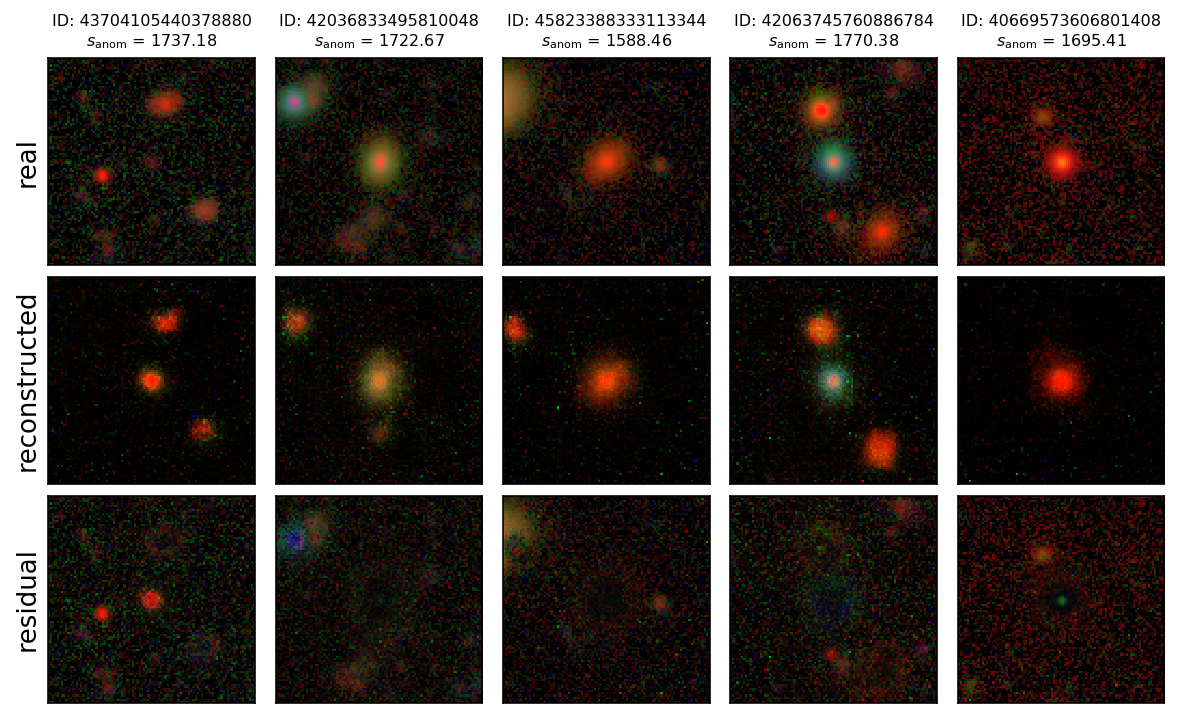

In [80]:
ids_01sig = get_anomalies(scores, ridxs, 0, 1)
plot_recons(ids_01sig)

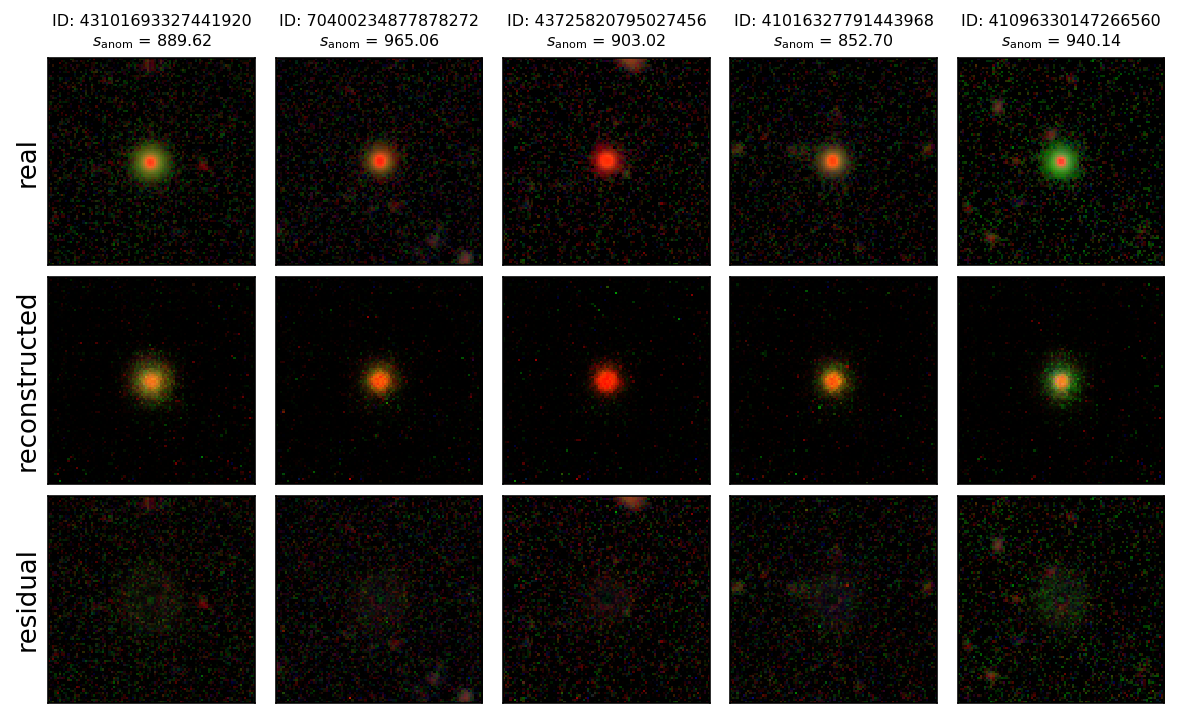

In [82]:
ids_n3n2sig = get_anomalies(scores, ridxs, -3, -2)
plot_recons(ids_n3n2sig)